## 2. Modelo de Previsão de Precipitação com Machine Learning
### Crie um sistema de previsão de chuva combinando dados meteorológicos multivariados:
### Etapas:
- Use features como pressão atmosférica, umidade, temperatura, velocidade do vento e índices atmosféricos
- Implemente modelos ensemble (Random Forest, XGBoost, LSTM) para previsão de precipitação
- Gere visualizações de importância de features, mapas de probabilidade de chuva e métricas de performance
- Desenvolva relatórios automatizados com acurácia por região e sazonalidade

Este sistema combina técnicas de machine learning com dados meteorológicos multivariados para prever a ocorrência de precipitação. O modelo integra múltiplas fontes de dados e abordagens de modelagem para fornecer previsões precisas e interpretáveis.
Arquitetura do Sistema
1. Coleta e Pré-processamento de Dados

    Fontes de dados: Estações meteorológicas, satélites, radares

    Variáveis incluídas:

        Pressão atmosférica (hPa)

        Umidade relativa (%)

        Temperatura (°C)

        Velocidade e direção do vento (m/s, graus)

        Índices atmosféricos (NAO, SOI, etc.)

        Dados históricos de precipitação

2. Engenharia de Features

    Criação de features temporais (médias móveis, tendências)

    Normalização e padronização dos dados

    Tratamento de valores ausentes e outliers

### Dependencias do projeto

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import geopandas as gpd


### Desenvolvimento do modelo

/home/brunojatoba92/codigos_dev_python/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
Métricas dos modelos:
               acuracia   roc_auc
random_forest  0.470000  0.472225
xgboost        0.480000  0.480733
lstm           0.533333  0.541026
ensemble       0.430000  0.431588


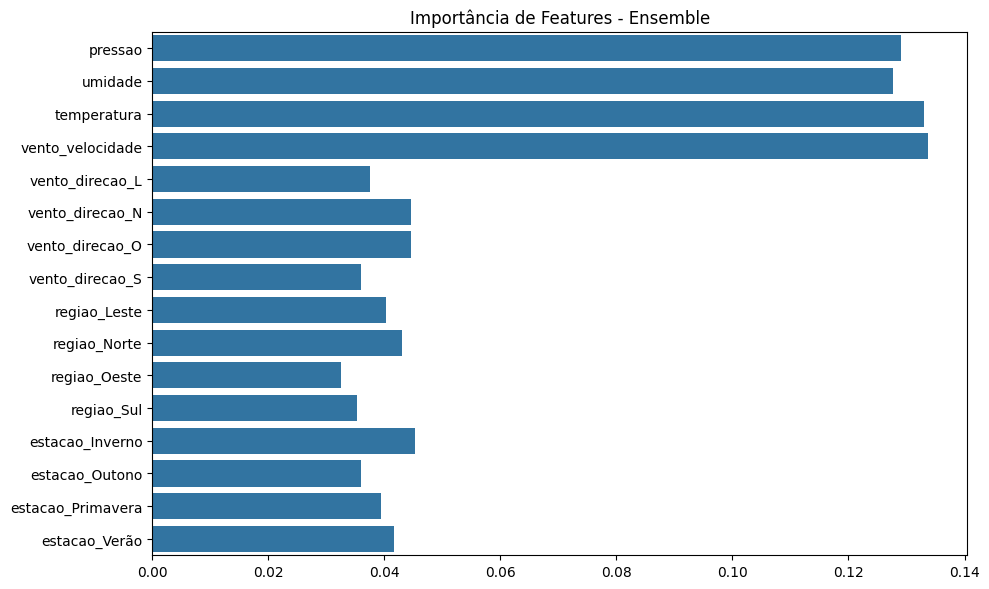

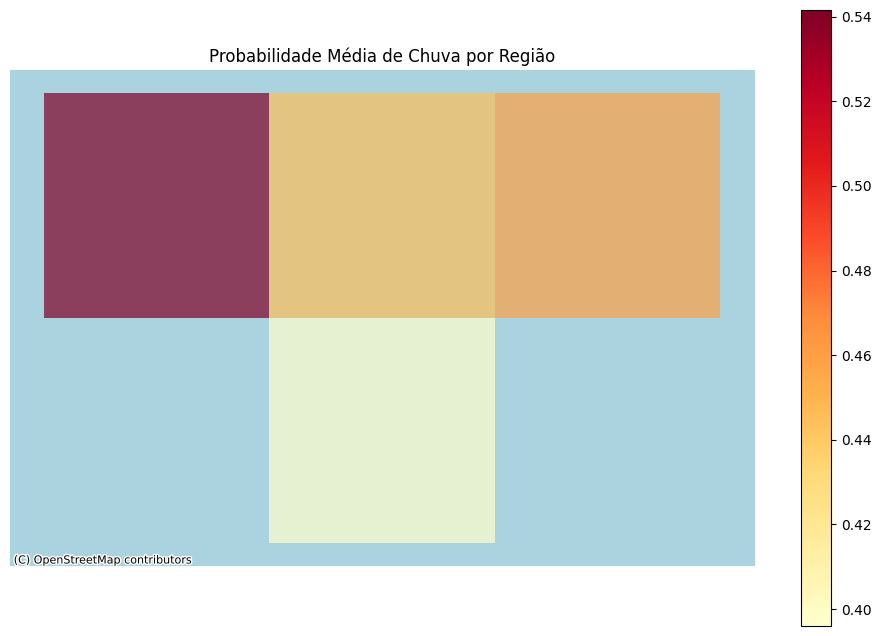


Acurácia por região:
  Região  Acurácia
0  Oeste  0.466667
1  Norte  0.471698
2    Sul  0.418182
3  Leste  0.361702

Acurácia por estação:
     Estação  Acurácia
0      Verão  0.450980
1     Outono  0.339623
2  Primavera  0.479167
3    Inverno  0.458333


In [17]:
class PrevisaoPrecipitacao:
    def __init__(self, dados_meteorologicos, dados_geograficos=None):
        """
        Inicializa o sistema de previsão de precipitação.
        
        Args:
            dados_meteorologicos (DataFrame): DataFrame com os dados meteorológicos
            dados_geograficos (GeoDataFrame, optional): Dados geoespaciais das regiões. Defaults to None.
        """
        self.dados = dados_meteorologicos
        self.dados_geo = dados_geograficos
        self.modelos = {}
        self.ensemble = None
        self.preprocessor = None
        self.historico_metricas = pd.DataFrame()
        self.feature_names = []
        
    def preprocessar_dados(self, target_col='precipitacao', test_size=0.2):
        """
        Pré-processa os dados para modelagem.
        
        Args:
            target_col (str): Nome da coluna alvo. Defaults to 'precipitacao'.
            test_size (float): Proporção para dados de teste. Defaults to 0.2.
        """
        # Limpeza de dados
        self.dados = self.dados.dropna()
        
        # Separar features e target
        self.X = self.dados.drop(columns=[target_col])
        self.y = self.dados[target_col]
        
        # Identificar colunas numéricas e categóricas
        numeric_cols = self.X.select_dtypes(include=['number']).columns.tolist()
        categorical_cols = self.X.select_dtypes(exclude=['number']).columns.tolist()
        
        # Criar pré-processador
        numeric_transformer = StandardScaler()
        categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        
        self.preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_cols),
                ('cat', categorical_transformer, categorical_cols)
            ])
        
        # Aplicar pré-processamento
        self.X_processed = self.preprocessor.fit_transform(self.X)
        
        # Obter nomes das features após one-hot encoding
        if len(categorical_cols) > 0:
            cat_features = self.preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
            self.feature_names = numeric_cols + list(cat_features)
        else:
            self.feature_names = numeric_cols
        
        # Split treino-teste
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X_processed, self.y, test_size=test_size, random_state=42
        )
        
    def treinar_modelos(self, timesteps=5):
        """
        Treina os modelos individuais e o ensemble.
        
        Args:
            timesteps (int): Número de passos temporais para LSTM. Defaults to 5.
        """
        # Converter para array denso se for sparse matrix
        X_train = self.X_train.toarray() if hasattr(self.X_train, 'toarray') else self.X_train
        X_test = self.X_test.toarray() if hasattr(self.X_test, 'toarray') else self.X_test
        
        # Random Forest
        self.modelos['random_forest'] = RandomForestClassifier(n_estimators=100, random_state=42)
        self.modelos['random_forest'].fit(X_train, self.y_train)
        
        # XGBoost
        self.modelos['xgboost'] = XGBClassifier(learning_rate=0.1, n_estimators=100, random_state=42)
        self.modelos['xgboost'].fit(X_train, self.y_train)
        
        # Preparar dados para LSTM
        X_train_lstm = self._preparar_dados_lstm(X_train, timesteps)
        X_test_lstm = self._preparar_dados_lstm(X_test, timesteps)
        
        # LSTM
        self.modelos['lstm'] = self._construir_modelo_lstm(
            input_shape=(timesteps, X_train.shape[1])
        )
        self.modelos['lstm'].fit(
            X_train_lstm, self.y_train.iloc[timesteps:], 
            epochs=10, batch_size=32, validation_split=0.2, verbose=0
        )
        
        # Ensemble (sem LSTM por ser sequencial)
        self.ensemble = VotingClassifier(estimators=[
            ('rf', self.modelos['random_forest']),
            ('xgb', self.modelos['xgboost'])
        ], voting='soft')
        self.ensemble.fit(X_train, self.y_train)
    
    def _preparar_dados_lstm(self, dados, timesteps):
        """Prepara os dados no formato sequencial para LSTM."""
        X = []
        for i in range(timesteps, len(dados)):
            X.append(dados[i-timesteps:i, :])
        return np.array(X)
        
    def _construir_modelo_lstm(self, input_shape):
        """Constroi e compila o modelo LSTM."""
        model = Sequential([
            LSTM(64, input_shape=input_shape),
            Dense(1, activation='sigmoid')
        ])
        model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])
        return model
            
    def avaliar_modelos(self):
        """Avalia todos os modelos e armazena as métricas."""
        resultados = {}
        X_test = self.X_test.toarray() if hasattr(self.X_test, 'toarray') else self.X_test
        
        for nome, modelo in self.modelos.items():
            if nome == 'lstm':
                X_test_lstm = self._preparar_dados_lstm(X_test, 5)
                y_pred = (modelo.predict(X_test_lstm) > 0.5).astype(int)
                y_test = self.y_test.iloc[5:]
            else:
                y_pred = modelo.predict(X_test)
                y_test = self.y_test
            
            resultados[nome] = {
                'acuracia': accuracy_score(y_test, y_pred),
                'roc_auc': roc_auc_score(y_test, y_pred) if len(set(y_test)) > 1 else None,
                'relatorio': classification_report(y_test, y_pred, output_dict=True)
            }
        
        # Avaliar ensemble
        y_pred_ensemble = self.ensemble.predict(X_test)
        resultados['ensemble'] = {
            'acuracia': accuracy_score(self.y_test, y_pred_ensemble),
            'roc_auc': roc_auc_score(self.y_test, y_pred_ensemble) if len(set(self.y_test)) > 1 else None,
            'relatorio': classification_report(self.y_test, y_pred_ensemble, output_dict=True)
        }
        
        self.historico_metricas = pd.DataFrame.from_dict(resultados, orient='index')
        return self.historico_metricas
        
    def plot_importancia_features(self, modelo='ensemble'):
        """Plota a importância das features para o modelo especificado."""
        if modelo == 'random_forest':
            importancias = self.modelos['random_forest'].feature_importances_
        elif modelo == 'xgboost':
            importancias = self.modelos['xgboost'].feature_importances_
        elif modelo == 'ensemble':
            # Média das importâncias dos modelos do ensemble
            importancias = (
                self.modelos['random_forest'].feature_importances_ + 
                self.modelos['xgboost'].feature_importances_
            ) / 2
        else:
            raise ValueError("Modelo não suportado para análise de importância de features.")
            
        plt.figure(figsize=(10, 6))
        sns.barplot(x=importancias, y=self.feature_names)
        plt.title(f'Importância de Features - {modelo.capitalize()}')
        plt.tight_layout()
        plt.show()
    
    def plot_mapa_probabilidade(self, coluna_regiao='regiao'):
        """
        Plota mapa de probabilidade de chuva por região.
        
        Args:
            coluna_regiao (str): Nome da coluna que identifica as regiões. Defaults to 'regiao'.
        """
        if self.dados_geo is None:
            print("Dados geoespaciais não disponíveis")
            return
        
        # Calcular probabilidades
        prob_chuva = self.ensemble.predict_proba(self.X_test)[:, 1]
        dados_plot = pd.DataFrame(self.X_test, columns=self.feature_names)
        dados_plot['prob_chuva'] = prob_chuva
        dados_plot[coluna_regiao] = self.dados.loc[self.y_test.index, coluna_regiao]

        # Agregar por região
        media_por_regiao = dados_plot.groupby(coluna_regiao)['prob_chuva'].mean().reset_index()

        # Merge com dados geoespaciais
        mapa = self.dados_geo.merge(
            media_por_regiao,
            left_on=coluna_regiao,
            right_on=coluna_regiao
        )

        # Plotar mapa
        fig, ax = plt.subplots(figsize=(12,8))
        mapa.plot(column='prob_chuva', cmap='YlOrRd', legend=True, ax=ax, alpha=0.7)
        ctx.add_basemap(ax, crs=mapa.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
        plt.title('Probabilidade Média de Chuva por Região')
        ax.set_axis_off()
        plt.show()
        
    def gerar_relatorio(self, coluna_regiao=None, coluna_estacao=None):
        """
        Gera relatório automatizado com métricas de performance.
        
        Args:
            coluna_regiao (str, optional): Nome da coluna com identificação de região. Defaults to None.
            coluna_estacao (str, optional): Nome da coluna com identificação de estação. Defaults to None.
        """
        relatorio = {
            'metricas_gerais': self.historico_metricas,
            'analise_por_grupo': {}
        }
        
        X_test = self.X_test.toarray() if hasattr(self.X_test, 'toarray') else self.X_test
        
        # Análise por região se disponível
        if coluna_regiao and coluna_regiao in self.dados.columns:
            regioes = self.dados.loc[self.y_test.index, coluna_regiao]
            acc_por_regiao = []
            
            for regiao in regioes.unique():
                mask = regioes == regiao
                acc = accuracy_score(self.y_test[mask], self.ensemble.predict(X_test[mask]))
                acc_por_regiao.append({'Região': regiao, 'Acurácia': acc})
                
            relatorio['analise_por_grupo']['por_regiao'] = pd.DataFrame(acc_por_regiao)
        
        # Análise por estação se disponível
        if coluna_estacao and coluna_estacao in self.dados.columns:
            estacoes = self.dados.loc[self.y_test.index, coluna_estacao]
            acc_por_estacao = []
            
            for estacao in estacoes.unique():
                mask = estacoes == estacao
                acc = accuracy_score(self.y_test[mask], self.ensemble.predict(X_test[mask]))
                acc_por_estacao.append({'Estação': estacao, 'Acurácia': acc})
                
            relatorio['analise_por_grupo']['por_estacao'] = pd.DataFrame(acc_por_estacao)
        
        return relatorio

# Exemplo de uso corrigido:
if __name__ == "__main__":
    # Simular dados meteorológicos (incluindo colunas categóricas)
    dados = pd.DataFrame({
        'pressao': np.random.normal(1013, 10, 1000),
        'umidade': np.random.randint(30, 100, 1000),
        'temperatura': np.random.uniform(10, 35, 1000),
        'vento_velocidade': np.random.uniform(0, 20, 1000),
        'vento_direcao': np.random.choice(['N', 'S', 'L', 'O'], 1000),  # Coluna categórica
        'precipitacao': np.random.randint(0, 2, 1000),
        'regiao': np.random.choice(['Norte', 'Sul', 'Leste', 'Oeste'], 1000),  # Categórica
        'estacao': np.random.choice(['Verão', 'Outono', 'Inverno', 'Primavera'], 1000)  # Categórica
    })
    
    # Criar dados geoespaciais fictícios
    from shapely.geometry import Polygon
    
    regioes = {
        'Norte': Polygon([(0, 0), (1, 0), (1, 1), (0, 1)]),
        'Sul': Polygon([(0, -1), (1, -1), (1, 0), (0, 0)]),
        'Leste': Polygon([(1, 0), (2, 0), (2, 1), (1, 1)]),
        'Oeste': Polygon([(-1, 0), (0, 0), (0, 1), (-1, 1)])
    }
    
    dados_geo = gpd.GeoDataFrame(
        pd.DataFrame({'regiao': list(regioes.keys())}),
        geometry=list(regioes.values()),
        crs="EPSG:4326"  # Sistema de coordenadas WGS84
    )

    
    # Criar instância do sistema
    sistema = PrevisaoPrecipitacao(
        dados_meteorologicos=dados, 
        dados_geograficos=dados_geo
    )
    
    # Pré-processar dados
    sistema.preprocessar_dados()
    
    # Treinar modelos
    sistema.treinar_modelos()
    
    # Avaliar modelos
    metricas = sistema.avaliar_modelos()
    print("Métricas dos modelos:")
    print(metricas[['acuracia', 'roc_auc']])
    
    # Visualizações
    sistema.plot_importancia_features()

    # Mapa Probabilidade
    sistema.plot_mapa_probabilidade()
    
    # Gerar relatório
    relatorio = sistema.gerar_relatorio(coluna_regiao='regiao', coluna_estacao='estacao')
    print("\nAcurácia por região:")
    print(relatorio['analise_por_grupo']['por_regiao'])
    print("\nAcurácia por estação:")
    print(relatorio['analise_por_grupo']['por_estacao'])